# **Music Genre Classification using Autoencoder**


---



This project uses the GTZAN Music Genre Dataset to classify songs into genres using a deep autoencoder for feature compression and a neural network classifier for genre prediction.
We extract high-level features from precomputed data and apply deep learning for accurate genre recognition.



* *Name: M HARISH GAUTHAM*
* 22MIS0421

---



### **Import Libraries**

In [88]:
# Core Python & System
import os
import warnings
warnings.filterwarnings('ignore')

# Data & Math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

# Audio Processing
import librosa
import librosa.display

# Machine Learning & Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
from sklearn.decomposition import PCA

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# KaggleHub (Dataset Access)
import kagglehub

# Colab File Upload (for custom audio testing)
from google.colab import files


### **Load and Explore Dataset**

In [90]:
# Step 1: Load Dataset from KaggleHub

path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
csv_path = os.path.join(path, "Data", "features_3_sec.csv")

df = pd.read_csv(csv_path)
print("Dataset loaded:", df.shape)



Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Dataset loaded: (9990, 60)


In [91]:
# Step 2: Prepare Features and Labels

X = df.drop(columns=['filename', 'label'])
y = df['label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [52]:
# Step 3: Scale Features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure feature names are saved for prediction
scaler.feature_names_in_ = np.array(X.columns)

input_dim = X_train_scaled.shape[1]
print(f"Feature dimension: {input_dim}")


Feature dimension: 58


In [92]:
# Step 4: Build Autoencoder

encoding_dim = 64  # latent space size (can increase if underfitting)

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(input_layer)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.BatchNormalization()(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 58)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,634 (127.48 KB)

 Trainable params: 32,122 (125.48 KB)

 Non-trainable params: 512 (2.00 KB)

In [93]:
# Step 5: Train Autoencoder

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=80,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=1
)

# Extract encoder part
encoder = models.Model(inputs=input_layer, outputs=encoded)


Epoch 1/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1419 - val_loss: 0.3944
Epoch 2/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3439 - val_loss: 0.2614
Epoch 3/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2643 - val_loss: 0.2099
Epoch 4/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2188 - val_loss: 0.1736
Epoch 5/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1850 - val_loss: 0.1446
Epoch 6/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1569 - val_loss: 0.1187
Epoch 7/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1317 - val_loss: 0.0963
Epoch 8/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1102 - val_loss: 0.0779
Epoch 9/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0924 - val_loss: 0.0627
Epoch 10/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0779 - val_loss: 0.0499
Epoch 11/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0671 - val_loss: 0.0409
Epoch 12/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

In [94]:
# Step 6: Encode Features and Train Classifier

encoded_X_train = encoder.predict(X_train_scaled)
encoded_X_test = encoder.predict(X_test_scaled)

classifier = models.Sequential([
    layers.Input(shape=(encoding_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y_encoded)), activation='softmax')
])

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cls = classifier.fit(
    encoded_X_train, y_train,
    epochs=60,
    batch_size=64,
    validation_data=(encoded_X_test, y_test),
    verbose=1
)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1715 - loss: 2.7937 - val_accuracy: 0.4795 - val_loss: 1.5474
Epoch 2/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4161 - loss: 1.6117 - val_accuracy: 0.5501 - val_loss: 1.2225
Epoch 3/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5091 - loss: 1.3559 - val_accuracy: 0.6076 - val_loss: 1.0959
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5591 - loss: 1.2314 - val_accuracy: 0.6351 - val_loss: 1.0168
Epoch 5/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5892 - loss: 1.1499 - val_accuracy: 0.6647 - val_loss: 0.9723
Epoch 6/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6062 - loss: 1.0981 - val_accuracy: 0.6697 - val_loss: 0.9207
Epoch 7/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6420 - loss: 1.0487 - val_accuracy: 0.6927 - val_loss: 0.8843
Epoch 8/60
125/125 ━━━━━

In [95]:
# Step 7: Evaluate Classifier

y_pred = np.argmax(classifier.predict(encoded_X_test), axis=1)

acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc * 100:.2f}%\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Test Accuracy: 81.78%

              precision    recall  f1-score   support

       blues       0.75      0.88      0.81       200
   classical       0.90      0.95      0.92       199
     country       0.86      0.64      0.74       199
       disco       0.71      0.81      0.76       200
      hiphop       0.87      0.77      0.82       200
        jazz       0.81      0.87      0.84       200
       metal       0.91      0.93      0.92       200
         pop       0.90      0.82      0.86       200
      reggae       0.76      0.81      0.78       200
        rock       0.75      0.70      0.73       200

    accuracy                           0.82      1998
   macro avg       0.82      0.82      0.82      1998
weighted avg       0.82      0.82      0.82      1998



### **Visualizations**

**Autoencoder Loss**

~ How well features are reconstructed

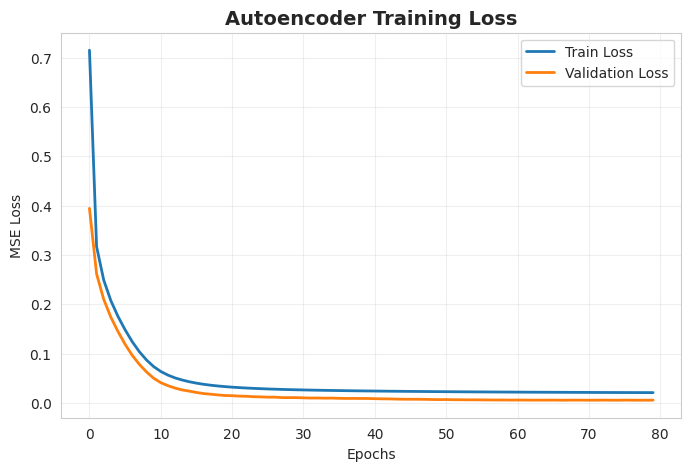

In [96]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Autoencoder Training Loss", fontsize=14, fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Classifier Accuracy/Loss**

~ Model learning behavior

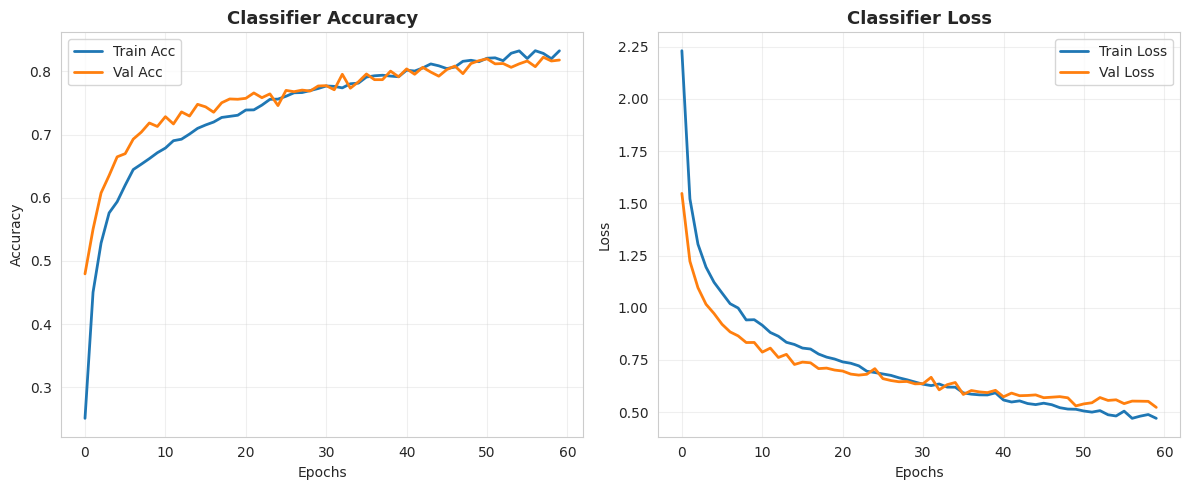

In [97]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_cls.history['accuracy'], label='Train Acc', linewidth=2)
plt.plot(history_cls.history['val_accuracy'], label='Val Acc', linewidth=2)
plt.title("Classifier Accuracy", fontsize=13, fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_cls.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_cls.history['val_loss'], label='Val Loss', linewidth=2)
plt.title("Classifier Loss", fontsize=13, fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**Confusion Matrix**

~ Correct vs misclassified genres

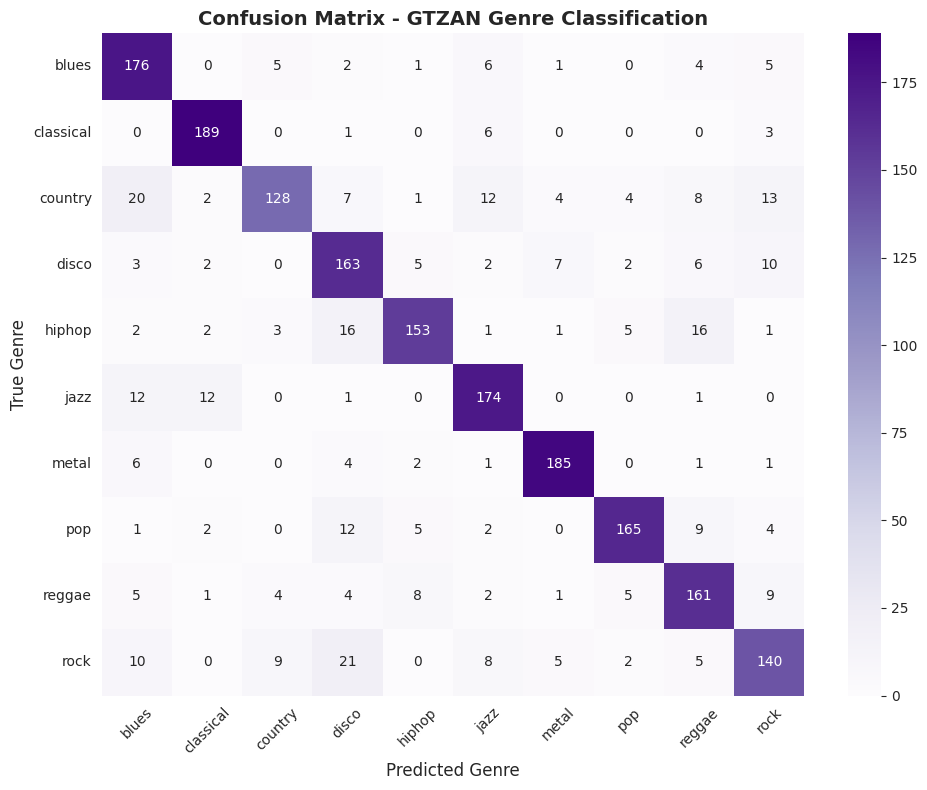

In [98]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Genre", fontsize=12)
plt.ylabel("True Genre", fontsize=12)
plt.title("Confusion Matrix - GTZAN Genre Classification", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Classification Report**

~ Precision, recall, F1 visually

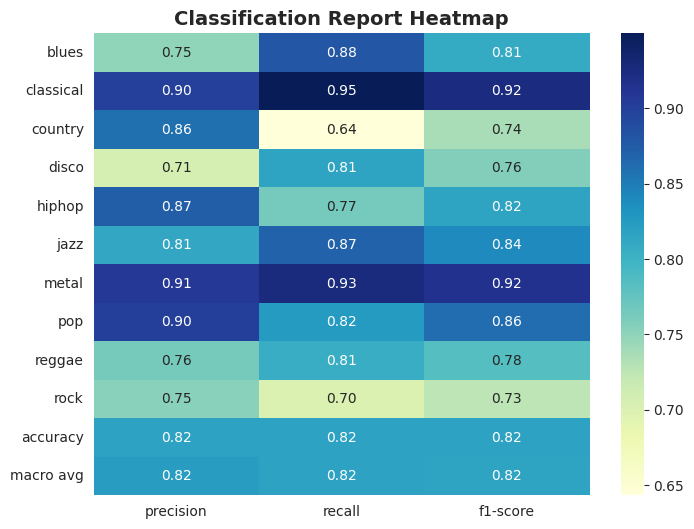

In [99]:
report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(8,6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap", fontsize=14, fontweight='bold')
plt.show()


### **Build Autoencoder**

In [69]:
def predict_genre_autoencoder(audio_path, encoder, classifier, scaler, label_encoder):
    try:
        y, sr = librosa.load(audio_path, sr=None)

        features = {
            'chroma_stft_mean': librosa.feature.chroma_stft(y=y, sr=sr).mean(),
            'chroma_stft_var': librosa.feature.chroma_stft(y=y, sr=sr).var(),
            'rms_mean': librosa.feature.rms(y=y).mean(),
            'rms_var': librosa.feature.rms(y=y).var(),
            'spectral_centroid_mean': librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
            'spectral_centroid_var': librosa.feature.spectral_centroid(y=y, sr=sr).var(),
            'spectral_bandwidth_mean': librosa.feature.spectral_bandwidth(y=y, sr=sr).mean(),
            'spectral_bandwidth_var': librosa.feature.spectral_bandwidth(y=y, sr=sr).var(),
            'rolloff_mean': librosa.feature.spectral_rolloff(y=y, sr=sr).mean(),
            'rolloff_var': librosa.feature.spectral_rolloff(y=y, sr=sr).var(),
            'zero_crossing_rate_mean': librosa.feature.zero_crossing_rate(y=y).mean(),
            'zero_crossing_rate_var': librosa.feature.zero_crossing_rate(y=y).var(),
            'harmony_mean': librosa.effects.harmonic(y=y).mean(),
            'harmony_var': librosa.effects.harmonic(y=y).var(),
            'perceptr_mean': librosa.effects.percussive(y=y).mean(),
            'perceptr_var': librosa.effects.percussive(y=y).var(),
            'tempo': librosa.beat.tempo(y=y, sr=sr)[0],
            'length': len(y) / sr
        }

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        for i in range(20):
            features[f'mfcc{i+1}_mean'] = mfccs[i].mean()
            features[f'mfcc{i+1}_var'] = mfccs[i].var()

        df_feat = pd.DataFrame([features])
        df_feat = df_feat[scaler.feature_names_in_]
        scaled = scaler.transform(df_feat)

        encoded = encoder.predict(scaled)
        probs = classifier.predict(encoded)[0]
        pred_idx = np.argmax(probs)
        genre = label_encoder.inverse_transform([pred_idx])[0]

        print("\nPredicted Genre:", genre)
        print("\nTop 3 Predictions:")
        for i in probs.argsort()[-3:][::-1]:
            print(f"  {label_encoder.inverse_transform([i])[0]} → {probs[i]*100:.2f}%")

        return genre

    except Exception as e:
        print(f"\nError processing file: {e}")
        return None


### **Predict on Custom Audio**

**Song 1:**

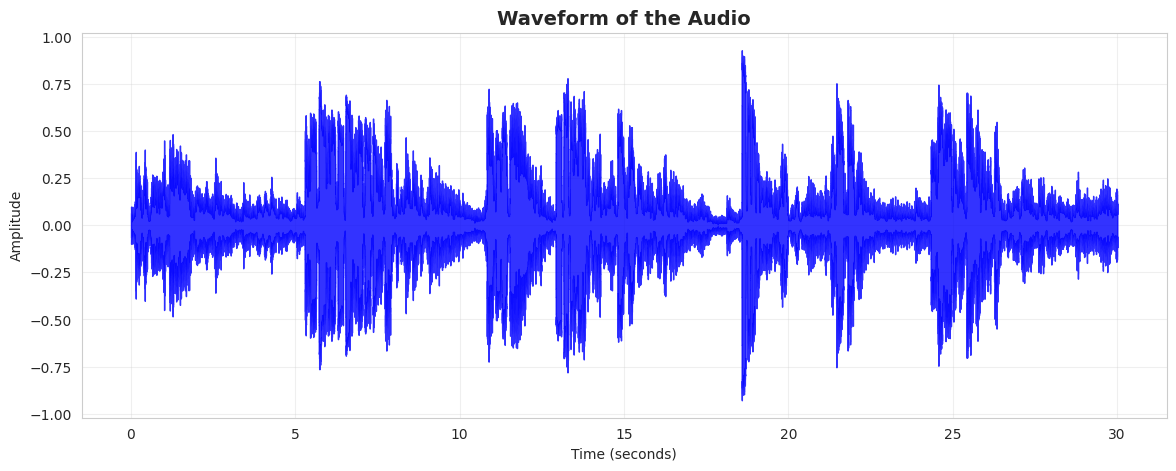

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Predicted Genre: jazz

Top 3 Predictions:
  jazz → 98.67%
  country → 0.95%
  blues → 0.27%


'jazz'

In [70]:
# Load the audio file (example)
audio_path = os.path.join(path, "Data", "genres_original", "jazz", "jazz.00042.wav")
audio_data, sr = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_data, sr=sr, alpha=0.8, color='b')
plt.title("Waveform of the Audio", fontsize=14, fontweight='bold')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.show()

predict_genre_autoencoder(audio_path, encoder, classifier, scaler, label_encoder)

**Song 2:**

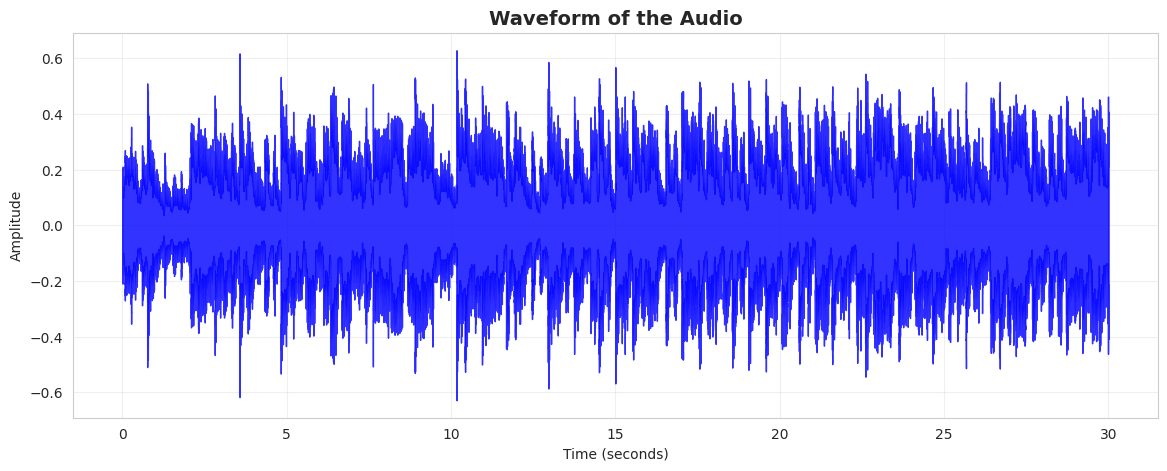

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Predicted Genre: rock

Top 3 Predictions:
  rock → 74.24%
  disco → 15.55%
  country → 6.22%


'rock'

In [71]:
# Load the audio file (example)
audio_path = os.path.join(path, "Data", "genres_original", "rock", "rock.00080.wav")
audio_data, sr = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_data, sr=sr, alpha=0.8, color='b')
plt.title("Waveform of the Audio", fontsize=14, fontweight='bold')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.show()


predict_genre_autoencoder(audio_path, encoder, classifier, scaler, label_encoder)

**Song 3:**

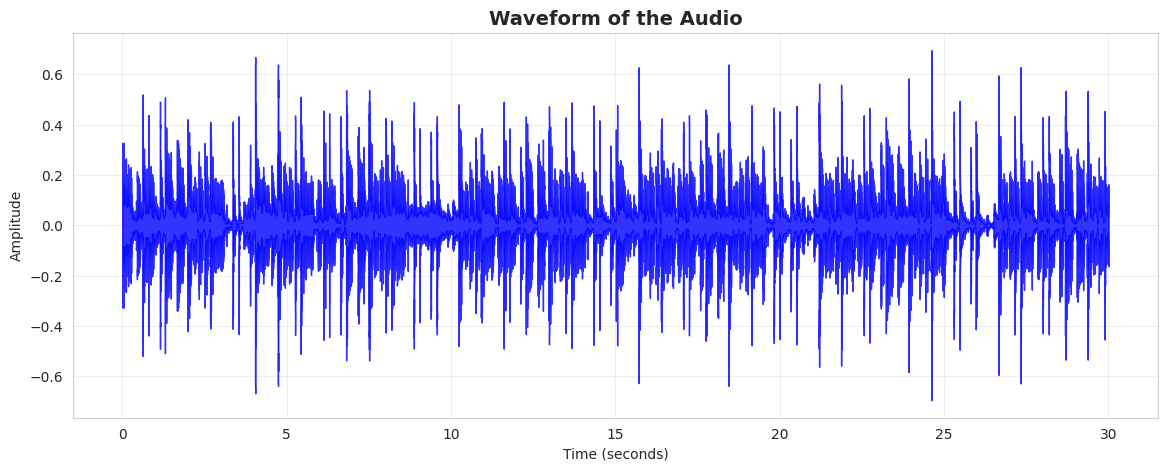

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Predicted Genre: reggae

Top 3 Predictions:
  reggae → 96.95%
  hiphop → 2.56%
  rock → 0.25%


'reggae'

In [72]:
# Load the audio file (example)
audio_path = os.path.join(path, "Data", "genres_original", "reggae", "reggae.00033.wav")
audio_data, sr = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_data, sr=sr, alpha=0.8, color='b')
plt.title("Waveform of the Audio", fontsize=14, fontweight='bold')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.show()


predict_genre_autoencoder(audio_path, encoder, classifier, scaler, label_encoder)

### **Upload and Predict Any Song**

**Song 1:**

Saving Do you remember this old Reggae song__.mp3 to Do you remember this old Reggae song__.mp3

Uploaded file: Do you remember this old Reggae song__.mp3



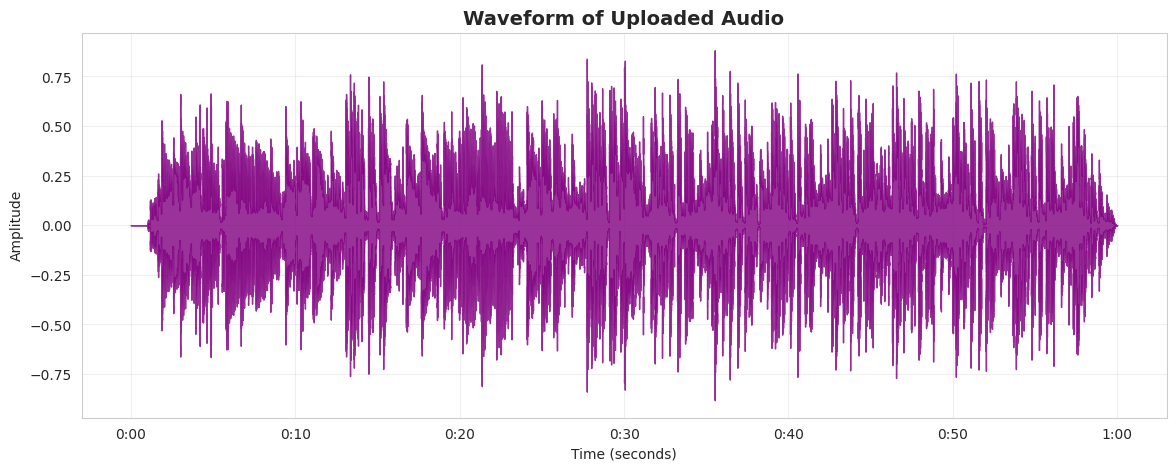

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Predicted Genre: reggae

Top 3 Predictions:
  reggae → 59.50%
  disco → 22.84%
  hiphop → 14.64%
The predicted genre for your uploaded song is: **reggae**


In [74]:
# Step 1: Upload your own audio file
uploaded = files.upload()

# Step 2: Get the uploaded filename
for filename in uploaded.keys():
    audio_file_path = filename
    print(f"\nUploaded file: {audio_file_path}\n")

#  Step 3: Load the audio file
audio_data, sr = librosa.load(audio_file_path, sr=None)

#  Step 4: Visualize waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_data, sr=sr, color='purple', alpha=0.8)
plt.title("Waveform of Uploaded Audio", fontsize=14, fontweight='bold')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.show()

# Step 5: Predict genre using your Autoencoder-based model
predicted_genre = predict_genre_autoencoder(
    audio_path=audio_file_path,
    encoder=encoder,
    classifier=classifier,
    scaler=scaler,
    label_encoder=label_encoder
)

# Step 6: Display result
print(f"The predicted genre for your uploaded song is: **{predicted_genre}**")


**Song 2:**

Saving Tum hi Ho WhatsApp Status Video Songs Aashiqui 2.mp3 to Tum hi Ho WhatsApp Status Video Songs Aashiqui 2.mp3

Uploaded file: Tum hi Ho WhatsApp Status Video Songs Aashiqui 2.mp3



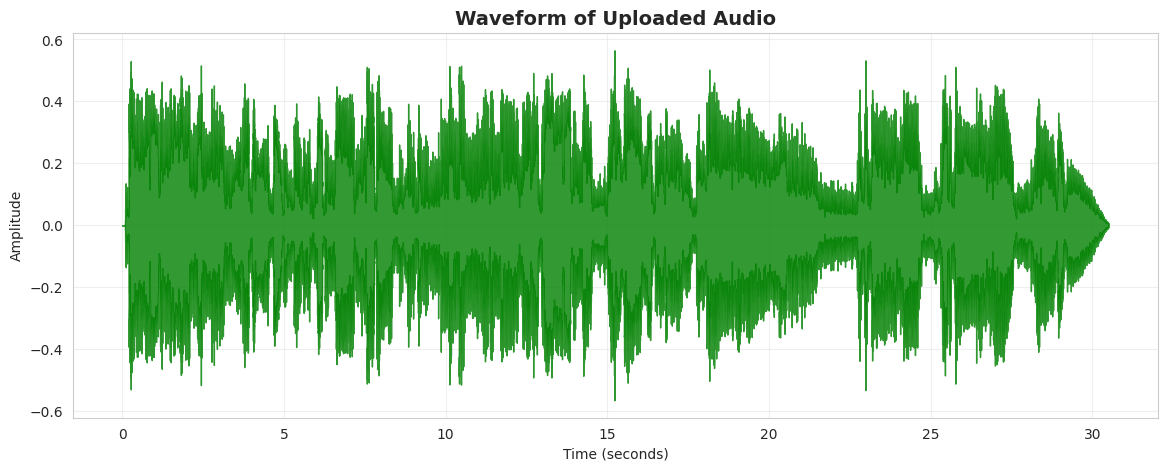

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Predicted Genre: blues

Top 3 Predictions:
  blues → 65.71%
  rock → 20.12%
  jazz → 3.18%
The predicted genre for your uploaded song is: blues


In [75]:
# Step 1: Upload your own audio file
uploaded = files.upload()

# Step 2: Get the uploaded filename
for filename in uploaded.keys():
    audio_file_path = filename
    print(f"\nUploaded file: {audio_file_path}\n")

#  Step 3: Load the audio file
audio_data, sr = librosa.load(audio_file_path, sr=None)

#  Step 4: Visualize waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_data, sr=sr, color='green', alpha=0.8)
plt.title("Waveform of Uploaded Audio", fontsize=14, fontweight='bold')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.show()

# Step 5: Predict genre using your Autoencoder-based model
predicted_genre = predict_genre_autoencoder(
    audio_path=audio_file_path,
    encoder=encoder,
    classifier=classifier,
    scaler=scaler,
    label_encoder=label_encoder
)

# Step 6: Display result
print(f"The predicted genre for your uploaded song is: {predicted_genre}")


*Verifying Output From Google:*

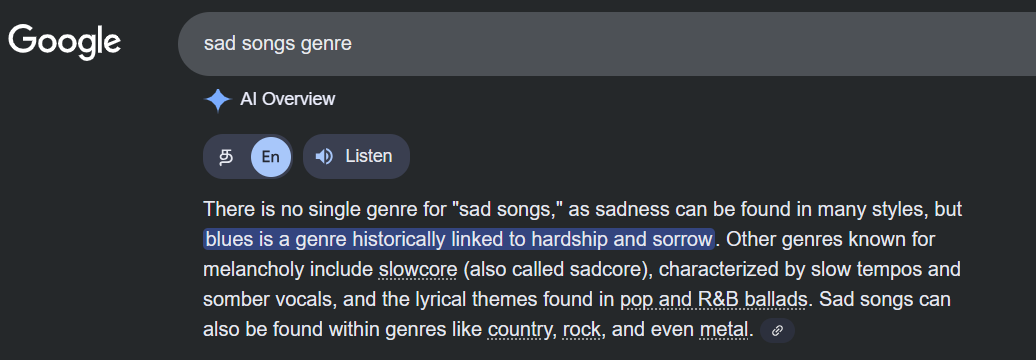